# Instituto de Educação Superior de Brası́lia – IESB
## Pós-Graduação em Inteligência Artificial
### Deep Learning e Redes Neurais

### Atividade 1 - Classificação de imagens na base de dados CIFAR-10 utilizando MLP

#### Descrição do Dataset CIFAR-10

O dataset CIFAR-10 consiste de 60 mil imagens coloridas, com 10 classes distintas igualmente balanceadas (isto é, 6 mil imagens por classe).

O conjunto é separado em 50 mil imagens para treinamento e 10 mil para teste.

As imagens são de animais e objetos, com as seguintes classes:


  - 0 - Avião										
  - 1 - Automóvel
  - 2 - Pássaro
  - 3 - Gato
  - 4 - Cervo
  - 5 - Cachorro
  - 6 - Sapo
  - 7 - Cavalo
  - 8 - Barco
  - 9 - Caminhão

Fonte: https://www.cs.toronto.edu/~kriz/cifar.html

## 1) Dataset

 - Carregue o dataset.
```python
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
```

 - Escolha, aletoriamente (e de forma automatizada), 16 imagens na base de treino, e apresente-as visualmente em um gráfico 4x4 (subplot).
 
 
 - Verifique se as dimensões dos tensores estão de acordo com a descrição do dataset.


 - Realize, caso necessário, pré-processamento nos dados. (Ex: normalização, padronização, codificação de classes, etc).

In [1]:
import sys
#!{sys.executable} -m pip uninstall -y tensorflow
#!{sys.executable} -m pip install tensorflow==2.5.0
#!{sys.executable} -m pip install tensorflow-gpu==2.5.0

import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools

tf.config.experimental.list_physical_devices('GPU')



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow.keras.datasets import cifar10

class_names = [
  'Avião', 'Automóvel', 'Pássaro', 'Gato', 'Veado',
  'Cachorro', 'Sapo', 'Cavalo', 'Navio', 'Caminhão'
]

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print( 'Formato dos dados originais:')
print( '    data: {'+np.array_str(X_train[:1])[:80]+'(...)' )
print( '  labels: '+np.array_str(y_train[:5])[:80]+'(...)' )



Formato dos dados originais:
    data: {[[[[ 59  62  63]
   [ 43  46  45]
   [ 50  48  43]
   ...
   [158 132 108]
   [1(...)
  labels: [[6]
 [9]
 [9]
 [4]
 [1]](...)


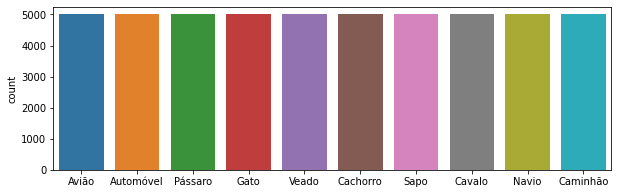

In [3]:
import matplotlib.pyplot as plt

def bloco():

    plt.figure(figsize=(10,3))
    p = sns.countplot(x=y_train.flatten())
    p.set(xticklabels=class_names)

bloco()

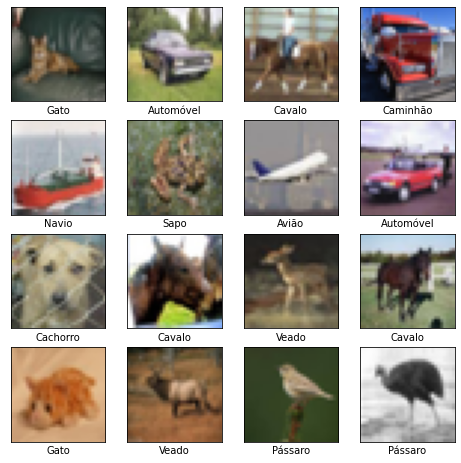

In [4]:
import matplotlib.pyplot as plt
import random as rnd

def bloco():

    szx = 4
    szy = 4
    plt.figure( figsize=[8,8] )
    for i in range( szx * szy ):
        r = rnd.randint( 0, len(X_train) )
        plt.subplot( szx, szy, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow( X_train[r], cmap=plt.cm.binary )
        plt.xlabel( class_names[ y_train.flatten()[ r ] ] )

    plt.show()

bloco()


In [5]:
import random;

def bloco():
    global X_train, y_train, X_test, y_test, X_validation, y_validation
    
    # converte a entrada para um tensor único de 50.000x32x32x3
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3)
    
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    # simpifica o conjunto de labels
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    # aplica a codificação one_hot para as classes, ou seja:
    #    1 - 0 0 0 0 0 0 1
    #    2 - 0 0 0 0 0 1 0
    #    3 - 0 0 0 0 1 0 0
    #    (...) cada valor distinto vira uma coluna com 0 ou 1.    
    y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
    y_test = tf.one_hot(y_test.astype(np.int32), depth=10)
    
    print( 'Padroniza as imagens...')
    print( '    data: '+str(X_train[:1]).replace('\n','')[:80]+'(...)' )
    print( '  labels: '+str(y_train[:5]).replace('\n','')[:80]+'(...)' )

bloco()


Padroniza as imagens...
    data: [[[[0.23137255 0.24313725 0.24705882]   [0.16862745 0.18039216 0.17647059]   [0.(...)
  labels: tf.Tensor([[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] [0. 0(...)


## 2) Implementação do Modelo MLP

### 2.1 Arquitetura

 - Defina uma arquitera MLP utilzando a API Sequencial do Keras.
 
 
 - A escolha de parâmetros do modelo, como, por exemplo, *quantidade de camadas ocultas*, *quantidade de neurônios*, *funções de ativação*, fica a critério do projetista. 


 - Apresente um resumo da arquitetura implementada

In [71]:
mp_num_classes = len(class_names)

# esta estrutura está parecida com a que eu peguei no Kaggle
# eu testei divesas variações, mas esta acabou sendo a melhor estrutura mesmo

model = tf.keras.models.Sequential([    
    tf.keras.layers.Conv2D( filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(32,32,3) ),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D( filters=32, kernel_size=(3,3), activation='relu', padding='same' ),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D( filters=32, kernel_size=(3,3), activation='relu', padding='same' ),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D( filters=32, kernel_size=(3,3), activation='relu', padding='same' ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(mp_num_classes, activation='softmax')
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=0.0001, 
        decay=1e-06
    ),    
    loss='categorical_crossentropy', 
    metrics=['acc']
)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
dropout_22 (Dropout)         (None, 16, 16, 32)       

### 2.3 Treinamento e Validação 
 
 - Defina a quantidade máxima de épocas para o treinamento.
 
 
 - Utilize alguma rotina de *callback* para que o treinamento não dure o máximo de épocas definido, caso isso não seja necessário.

 
 - Utilize, também, uma rotina de *callback* que salve o binário do modelo que obteve melhor acurácia na base de validação, durante as épocas de treinamento.


 - Utilize 20% da base de treino para validar o modelo a cada época.  <br>
   (Consulte os parametros do método *fit*)


 - Mostre em um gráfico o comportamento da função custo (*loss*) e da acurácia, ao longo das epócas, para as bases de treino e de validação.
 
 
 - O modelo deve atingir um mínimo de **50%** de acurácia média na base de teste. <br>
   Caso não atinja essa meta, revise a arquitetura definida.

In [47]:
def bloco():
    
    nonlocal history

    mp_epochs=50
    mp_batch_size = 20

    my_callbacks = [
        # abandona o processamento se a acurácia não melhorar em até {patitence} épocas
        tf.keras.callbacks.EarlyStopping(monitor='val_acc',patience=4), 
        # grava os modelos intermediários
        tf.keras.callbacks.ModelCheckpoint(filepath='model/model.{epoch:02d}.h5'), # salva o modelo para poder retomar o treinamento
        # grava informações para visualização
        # tf.keras.callbacks.TensorBoard(log_dir='./logs'), 
    ]

    history = model.fit(
        X_train, 
        y_train, 
        batch_size=mp_batch_size,
        epochs=mp_epochs,
        callbacks=my_callbacks,
        validation_split=0.2
    )

bloco()

Epoch 1/50
2000/2000 [==============================] - 39s 19ms/step - loss: 1.8406 - acc: 0.3336 - val_loss: 1.7695 - val_acc: 0.3674
Epoch 2/50
2000/2000 [==============================] - 38s 19ms/step - loss: 1.5500 - acc: 0.4424 - val_loss: 1.4980 - val_acc: 0.4868
Epoch 3/50
2000/2000 [==============================] - 38s 19ms/step - loss: 1.4100 - acc: 0.4919 - val_loss: 1.3401 - val_acc: 0.5324
Epoch 4/50
2000/2000 [==============================] - 39s 20ms/step - loss: 1.3047 - acc: 0.5353 - val_loss: 1.2565 - val_acc: 0.5693
Epoch 5/50
2000/2000 [==============================] - 39s 19ms/step - loss: 1.2259 - acc: 0.5619 - val_loss: 1.1959 - val_acc: 0.5891
Epoch 6/50
2000/2000 [==============================] - 38s 19ms/step - loss: 1.1656 - acc: 0.5841 - val_loss: 1.1412 - val_acc: 0.5989
Epoch 7/50
2000/2000 [==============================] - 38s 19ms/step - loss: 1.1215 - acc: 0.6039 - val_loss: 1.0874 - val_acc: 0.6175
Epoch 8/50
2000/2000 [==========================

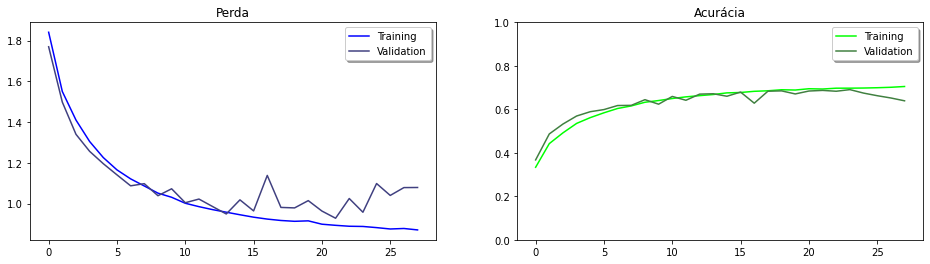

In [48]:
def bloco():

    fig, ax = plt.subplots(1,2,figsize=(16, 4))
    ax[0].set_title('Perda')
    ax[0].plot(history.history['loss'], color='#0000FF', label="Training")
    ax[0].plot(history.history['val_loss'], color='#404080', label="Validation")
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].set_title('Acurácia')
    ax[1].plot(history.history['acc'], color='#00FF00', label="Training")
    ax[1].plot(history.history['val_acc'], color='#408040', label="Validation")
    ax[1].set_ylim([0.0,1.0])
    legend = ax[1].legend(loc='best', shadow=True)

bloco()

In [68]:
def bloco():
    
    print( 'Seleciona o modelo com maior acurácia durante a validação (usualmente antes do overfit)' )
    
    best_acc = max(history.history['val_acc'])
    best_epoch = history.history['val_acc'].index(best_acc) + 1
    
    print( f'melhor epoca: {best_epoch} val_acc={best_acc:1.2f}' )    
        
    model.load_weights( f'model/model.{best_epoch:02d}.h5' )

bloco()

Seleciona o modelo com maior acurácia durante a validação (usualmente antes do overfit)
melhor epoca: 24 val_acc=0.69


### 2.4 Desempenho na Base de Teste

 - Realize, com o modelo treinado, predições na base de teste (método *predict*).
 

 - Com as predições, calcule a precisão e a revocação para cada classe.  <br>
   (Pode ser utilizada a função *classification_report* do *scikit-learn* ou alguma outra similar).

              precision    recall  f1-score   support

       Avião       0.66      0.80      0.72      1000
   Automóvel       0.84      0.77      0.80      1000
     Pássaro       0.69      0.45      0.54      1000
        Gato       0.51      0.50      0.50      1000
       Veado       0.58      0.68      0.62      1000
    Cachorro       0.60      0.54      0.57      1000
        Sapo       0.75      0.79      0.77      1000
      Cavalo       0.67      0.78      0.72      1000
       Navio       0.83      0.74      0.79      1000
    Caminhão       0.75      0.81      0.78      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.68     10000
weighted avg       0.69      0.69      0.68     10000



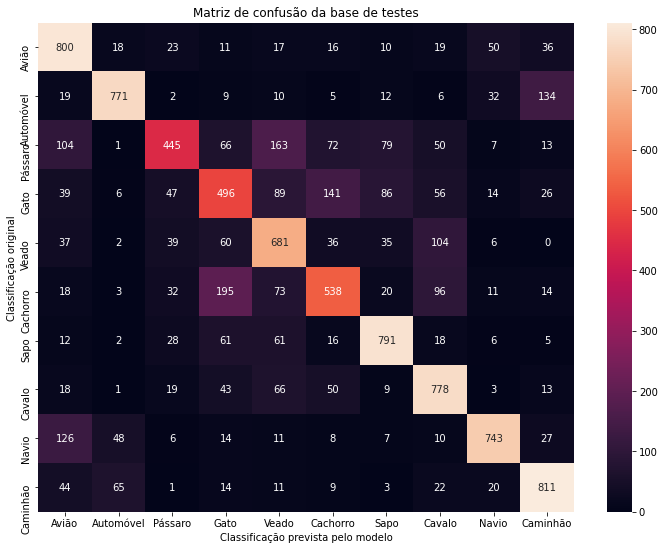

In [69]:
from sklearn.metrics import classification_report

def bloco():
    
    # Predict the values from the validation dataset
    y_pred = model.predict(X_test)
    # Convert predictions classes to one hot vectors 
    y_pred_classes = np.argmax(y_pred, axis = 1) 
    # Convert validation observations to one hot vectors
    y_true = np.argmax(y_test, axis = 1)
    # compute the confusion matrix
    
    print( classification_report( y_true, y_pred_classes, target_names=class_names ) )
    
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)
    
    plt.figure(figsize=(12, 9))
    plt.title( 'Matriz de confusão da base de testes' )
    c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
    c.set(xlabel='Classificação prevista pelo modelo', ylabel='Classificação original')
    c.set(xticklabels=class_names, yticklabels=class_names)

    return None
    
bloco()

# Referências utilizadas

* https://www.kaggle.com/amyjang/tensorflow-cifar10-cnn-tutorial

* https://www.tensorflow.org/guide/keras/sequential_model#a_common_debugging_workflow_add_summary

* https://keras.io/api/callbacks/

* https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

